<a href="https://colab.research.google.com/github/Fatemehss94/amlg/blob/main/project_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os
import sys

# Append the root of the Git repository to the path
git_root = os.popen(cmd="git rev-parse --show-toplevel").read().strip()
sys.path.append(git_root)

from src.exercises.perturbation_data_analysis import pertdata as pt  # noqa: E402

norman = pt.PertData.from_repo(name="norman", save_dir="data")

print(norman)

Creating dataset directory: data/norman
Downloading: https://seafile.cloud.uni-hannover.de/d/5d6029c6eaaf410c8b01/files/?p=%2Fperturbation_data_analysis%2Fnorman%2Fperturb_processed.h5ad&dl=1 -> data/norman/perturb_processed.h5ad
Total size: 2,228,610,012 bytes


100%|██████████| 2.23G/2.23G [14:20<00:00, 2.59MiB/s]


Download completed: data/norman/perturb_processed.h5ad
Loading dataset: norman
PertData object
    name: norman
    path: data/norman
    adata: AnnData object with n_obs x n_vars = 91205 x 5045


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import torch
from PIL import Image
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision
import torch.nn as nn
from torch.optim import Adam
import torch.optim as optim
from tqdm import tqdm
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset

**preprocessing data**

In [9]:
# access the gene expression matrix, the perturbations labels, the control labels, and the gene names
X = norman.adata.X
y_pert = norman.adata.obs["condition"]
y_ctrl = norman.adata.obs["control"]
gene_names = norman.adata.var["gene_name"]


#Filtering out double-gene perturbations
filter_mask = ~norman.adata.obs["condition_fixed"].str.contains(r"\+")
indexes_to_keep = filter_mask[filter_mask].index
adata_single = norman.adata[indexes_to_keep].copy()


# Selecting high-variance genes
d = 128
# Compute the gene variances
gene_variances = adata_single.X.toarray().var(axis=0)
# Sort the gene variances in descending order and get the indexes of the top d genes
sorted_indexes = gene_variances.argsort()[::-1]
# Get the indexes of the top d genes
top_gene_indexes = sorted_indexes[:d]
# Get the gene names of the top d genes
top_genes = adata_single.var["gene_name"].iloc[top_gene_indexes]
# Get the variances of the top d genes
top_variances = gene_variances[top_gene_indexes]
# Create a new AnnData object with only the top d genes
adata_single_top_genes = adata_single[:, top_gene_indexes].copy()
# Selecting high-variance gene



# Convert the gene expression matrix to a PyTorch tensor
X = torch.tensor(data=adata_single_top_genes.X.toarray(), dtype=torch.float32)


# Create a PyTorch dataset
dataset = TensorDataset(X, X)

# Create train and test datasets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(
    dataset=dataset, lengths=[train_size, test_size]
)

num_workers = 2
persistent_workers = False

# Train DataLoader
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=num_workers,
    persistent_workers=persistent_workers,
)

# Test DataLoader
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=num_workers,
    persistent_workers=persistent_workers,
)

**use the Autoencoder from the exercise**

In [14]:
"""This module defines an autoencoder model."""

import torch
from torch import nn

import pytorch_lightning as pl


class Encoder(nn.Module):
    """
    MLP encoder.

    Args:
        in_features: The number of input features.
        latent_dim: Dimension of the latent space.
    """

    def __init__(self, in_features: int, latent_dim: int) -> None:
        super().__init__()
        self.l1 = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=latent_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the encoder.

        Args:
            x: The input tensor.

        Returns:
            The encoded tensor.
        """
        return self.l1(x)


class Decoder(nn.Module):
    """
    MLP decoder.

    Args:
        latent_dim: Dimension of the latent space.
        out_features: The number of output features.
    """

    def __init__(self, latent_dim: int, out_features: int) -> None:
        super().__init__()
        self.l1 = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=out_features),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the decoder.

        Args:
            x: The input tensor.

        Returns:
            The encoded tensor.
        """
        return self.l1(x)


class Autoencoder(pl.LightningModule):
    """
    Simple Autoencoder model.

    Args:
        in_features: The number of input features.
        learning_rate: The learning rate for the optimizer.
    """

    def __init__(self, in_features: int, learning_rate: float = 1e-3) -> None:
        super().__init__()
        self.encoder = Encoder(in_features=in_features, latent_dim=64)
        self.decoder = Decoder(latent_dim=64, out_features=in_features)
        self.learning_rate = learning_rate
        self.loss_fn = nn.MSELoss()


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the autoencoder.

        Args:
            x: The input tensor.

        Returns:
            The reconstructed tensor.
        """
        return self.decoder(self.encoder(x))

    def training_step(self, batch, batch_idx):  # noqa: D102
        x, _ = batch
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = self.loss_fn(input=x_hat, target=x)

        # Log batch index and training loss
        self.log(name="batch_idx", value=int(batch_idx), prog_bar=True)
        self.log(name="train_loss", value=loss, prog_bar=True)

        return loss

    def test_step(self, batch):  # noqa: D102
        x, _ = batch
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = self.loss_fn(input=x_hat, target=x)

        # Log test loss
        self.log(name="test_loss", value=loss, prog_bar=True)

    def configure_optimizers(self):  # noqa: D102
        optimizer = torch.optim.Adam(params=self.parameters(), lr=self.learning_rate)
        return optimizer

In [15]:
autoencoder = Autoencoder(in_features = X.shape[1])

In [16]:
from pytorch_lightning.loggers import CSVLogger

# Initialize the CSV logger
logger = CSVLogger(save_dir="lightning_logs", name="ae_experiment")

# Train the autoencoder
trainer = pl.Trainer(max_epochs=100, logger=logger)
trainer.fit(model=autoencoder, train_dataloaders=train_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 12.4 K | train
1 | decoder | Decoder | 12.5 K | train
2 | loss_fn | MSELoss | 0      | train
--------------------------------------------
24.9 K    Trainable params
0         Non-trainable params
24.9 K    Total params
0.100     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


**visualization of Autoencoder (64D) latent using TSNE vs PCA (2D) across four top conditions**

The visualization is focused on the most frequent fixed conditions in the dataset with distinct colors assigned to each condition for clarity. First, we identify the most frequent fixed conditions

In [13]:
condition_fixed = adata_single_top_genes.obs["condition_fixed"].values
condition_counts = pd.value_counts(condition_fixed)
print("Number of rows per unique fixed condition:")
print(condition_counts)

Number of rows per unique fixed condition:
ctrl      7353
KLF1      1641
BAK1      1171
CEBPE     1039
ETS2      1031
          ... 
NIT1       165
CDKN1C     165
ZBTB10     145
HES7       122
PLK4        97
Name: count, Length: 106, dtype: int64


<ipython-input-13-490ffa6dd642>:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  condition_counts = pd.value_counts(condition_fixed)


<ipython-input-60-2ad1ec4dcafa>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_autoencoded = autoencoder.encoder(torch.tensor(X_filtered).float()).detach().numpy()


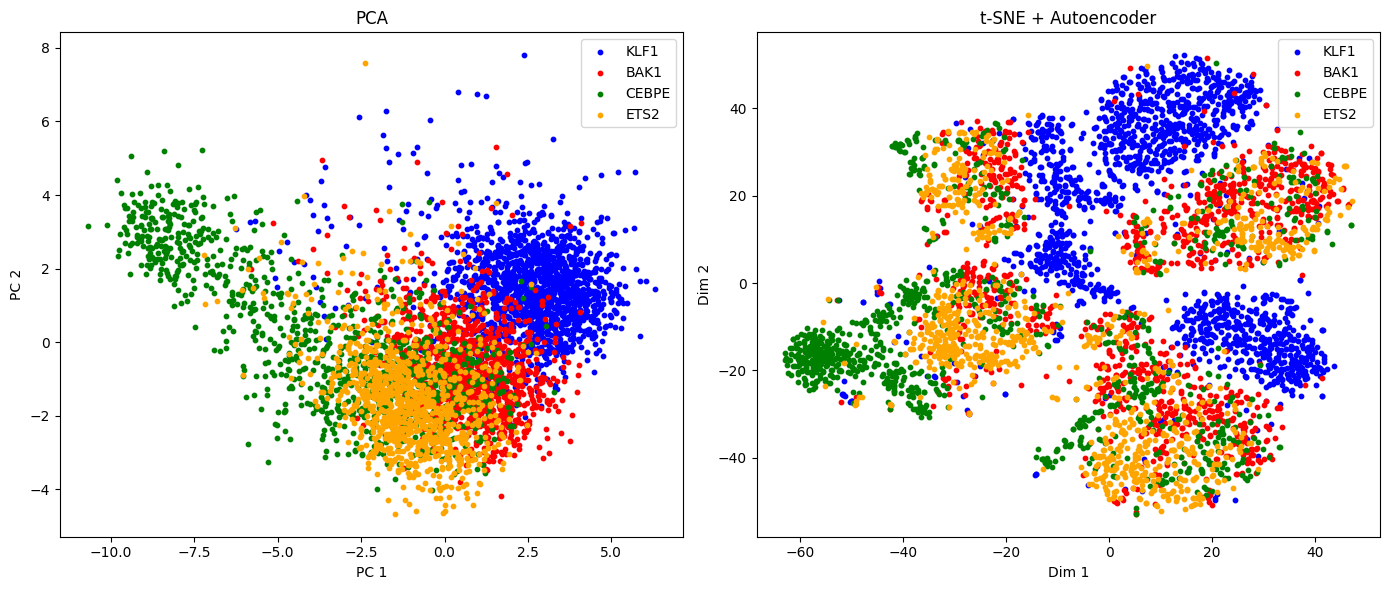

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import torch

# Step 1: Filter data for top conditions
top_conditions = ["KLF1", "BAK1", "CEBPE", "ETS2"]
condition_fixed = adata_single_top_genes.obs["condition_fixed"].values
condition_mask = pd.Series(condition_fixed).isin(top_conditions).values
X_filtered = X[condition_mask]
condition_filtered = condition_fixed[condition_mask]

# Step 2: Apply PCA (2 components)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_filtered)

# Step 3: Apply Autoencoder (64D embeddings)
X_autoencoded = autoencoder.encoder(torch.tensor(X_filtered).float()).detach().numpy()

# Step 4: Apply t-SNE to reduce Autoencoder embeddings to 2D
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_autoencoded)

# Step 5: Visualization
# Define a custom color palette
custom_palette = {"KLF1": "blue", "BAK1": "red", "CEBPE": "green", "ETS2": "orange"}
colors = [custom_palette[cond] for cond in condition_filtered]

fig = plt.figure(figsize=(14, 6))

# PCA 2D Visualization
ax1 = fig.add_subplot(121)
for cond in top_conditions:
    mask = condition_filtered == cond
    ax1.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        label=cond,
        c=custom_palette[cond],
        s=10,
    )
ax1.set_title("PCA")
ax1.set_xlabel("PC 1")
ax1.set_ylabel("PC 2")
ax1.legend()

# t-SNE 2D Visualization
ax2 = fig.add_subplot(122)
for cond in top_conditions:
    mask = condition_filtered == cond
    ax2.scatter(
        X_tsne[mask, 0],
        X_tsne[mask, 1],
        label=cond,
        c=custom_palette[cond],
        s=10,
    )
ax2.set_title("t-SNE + Autoencoder")
ax2.set_xlabel("Dim 1")
ax2.set_ylabel("Dim 2")
ax2.legend()

plt.tight_layout()
plt.show()


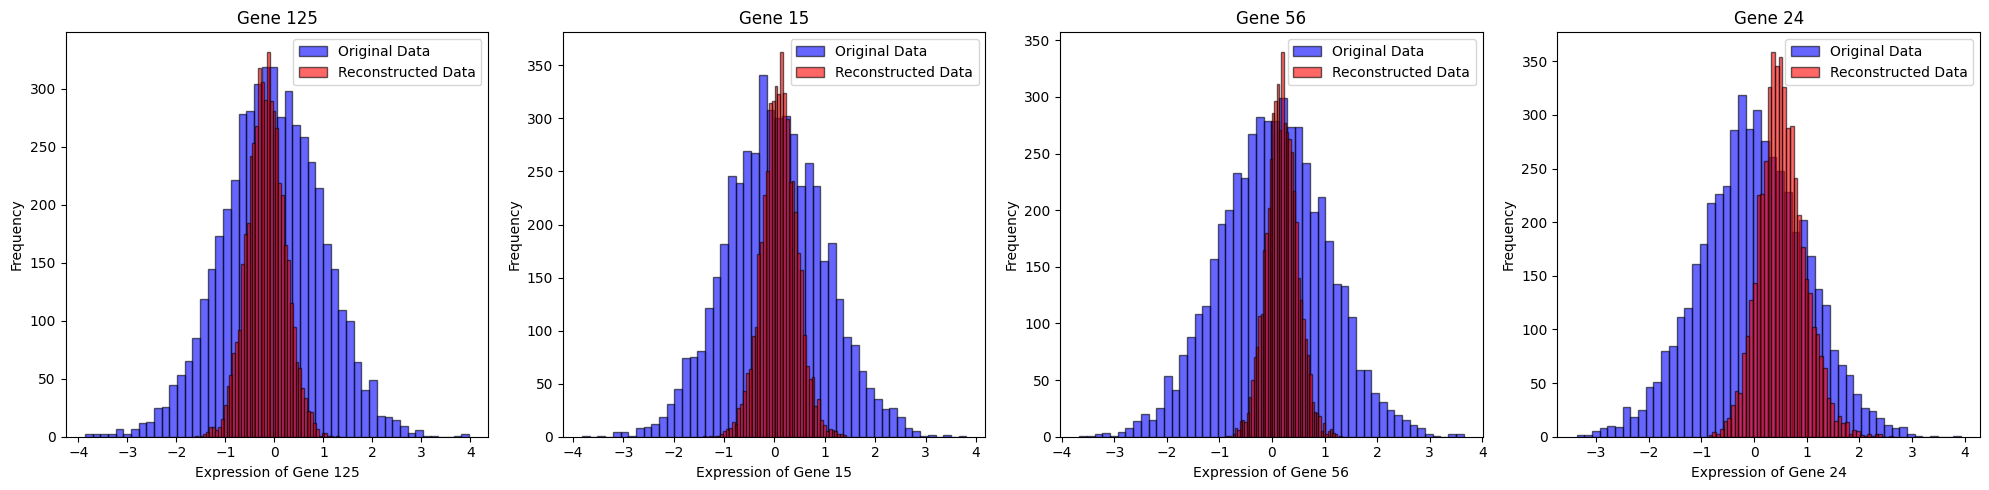

In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Generate random data
num_samples = 5000
num_genes = 128
random_data = torch.randn(num_samples, num_genes)

# Reconstruct the random data using the autoencoder
reconstructed_data = autoencoder(random_data).detach().numpy()

# Randomly select four genes for comparison
selected_genes = np.random.choice(num_genes, size=4, replace=False)

# Plot distributions
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, gene in enumerate(selected_genes):
    axes[i].hist(
        random_data[:, gene].numpy(),
        bins=50,
        alpha=0.6,
        label="Original Data",
        color="blue",
        edgecolor="black",
    )
    axes[i].hist(
        reconstructed_data[:, gene],
        bins=50,
        alpha=0.6,
        label="Reconstructed Data",
        color="red",
        edgecolor="black",
    )
    axes[i].set_title(f"Gene {gene}")
    axes[i].set_xlabel(f"Expression of Gene {gene}")
    axes[i].set_ylabel("Frequency")
    axes[i].legend()

plt.tight_layout()
plt.show()


**Autoencoder Architectures with Variable Latent Dimensions**

Training Progress: 100%|██████████| 100/100 [06:40<00:00,  4.01s/it, epoch_loss=0.0566]


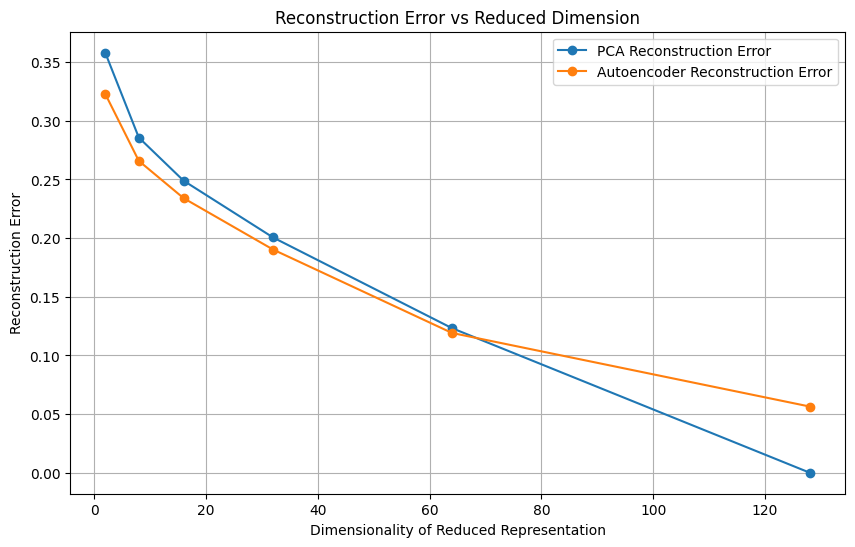

In [31]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Define the training function
def train_autoencoder(model, train_loader, optimizer, criterion, num_epochs):
    model.train()
    progress_bar = tqdm(range(num_epochs), desc="Training Progress")  # Progress bar for epochs
    for epoch in progress_bar:
        epoch_loss = 0
        for inputs, _ in train_loader:
            inputs = inputs.view(inputs.size(0), -1)  # Flatten input for linear layers
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        progress_bar.set_postfix(epoch_loss=epoch_loss/len(train_loader))

k_values = [2, 8, 16, 32, 64, 128]  # Different latent dimensions
pca_errors = []
autoencoder_errors = []

# Convert data to numpy for PCA and PyTorch for Autoencoder
X_numpy = X.numpy()

# Loop over latent dimensions
for k in k_values:
    # PCA
    pca_kd = PCA(n_components=k)
    X_pca_kd = pca_kd.fit_transform(X_numpy)
    X_pca_kd_reconstructed = pca_kd.inverse_transform(X_pca_kd)
    pca_error = ((X_numpy - X_pca_kd_reconstructed) ** 2).mean()
    pca_errors.append(pca_error)

    model = Autoencoder(input_dim=X.shape[1], latent_dim=k)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    num_epochs = 100
    train_autoencoder(model, train_loader, optimizer, criterion, num_epochs)

    # Reconstruct data
    model.eval()
    with torch.no_grad():
        X_autoencoded_reconstructed = model(X).numpy()
    autoencoder_error = ((X_numpy - X_autoencoded_reconstructed) ** 2).mean()
    autoencoder_errors.append(autoencoder_error)

# Plot Reconstruction Errors
plt.figure(figsize=(10, 6))
plt.plot(k_values, pca_errors, label="PCA Reconstruction Error", marker="o")
plt.plot(k_values, autoencoder_errors, label="Autoencoder Reconstruction Error", marker="o")
plt.xlabel("Dimensionality of Reduced Representation")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction Error vs Reduced Dimension")
plt.legend()
plt.grid()
plt.show()
